Welcome to my notebook on `Market Basket Analysis on Groceries`. This is done as part of *Individual Assignment 2* on *AI1030 - Python Programming* course at **MBZUAI**. 

In this assignment, we will analyze the real-life grocery dataset. We will start with loading and cleaning. Then, we will assign random values to the products. It is good for running everything even in Google Colab. After that, we will inspect frequently occuring pairs and triples and visualize them. 

This notebook is meant to be run top-to-bottom everything included. By everything, I mean from installing dependencies or downloading raw dataset all the way to visualizations. The report and comments will be clear and concise. Let's dive in:

# Setup and installation

We will start with installing dependencies. These include common libraries like `numpy`, `pandas`, `scipy`, `scikit-learn`, `matplotlib` and `seaborn`. We also included `networkx` to build network graph later.

In [ ]:
!pip install -q pandas==2.3.3
!pip install -q numpy==1.26.4
!pip install -q matplotlib==3.10.7 seaborn==0.13.2 networkx==3.4.2

We are disabling mostly unnecessary warnings.

In [2]:
import warnings

warnings.filterwarnings('ignore')

We will set all seeds to one number. This will help us immensely for reproduction. declare parameters here. Current parameters values are:
```python
SEED = 25
DATA_FOLDER = 'data/'
min_count = 20
K = 10
```
Feel free to change to your preferences

In [ ]:
import os
import random
import numpy as np

SEED = 25
DATA_FOLDER = 'data/'
min_count = 20
K = 10

FIGURE_SIZE = (12, 8)

def set_seed():
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

    print(f"All seeds set to {SEED}")

def download_initial_data(force_download=False):
    os.makedirs(DATA_FOLDER, exist_ok=True)

    if (not os.path.exists(f"{DATA_FOLDER}groceries.csv")) or force_download:
        !wget -O "{DATA_FOLDER}groceries.csv" -q https://raw.githubusercontent.com/murodbecks/groceries_analysis/refs/heads/main/data/groceries.csv

        print(f"Initial data is saved to '{DATA_FOLDER}groceries.csv' file")
    else:
        print(f"'{DATA_FOLDER}groceries.csv' already exists.")

os.makedirs("files/", exist_ok=True)
set_seed()
download_initial_data()

All seeds set to 25
'data/groceries.csv' already exists.


# A. Load & Understand

Now, it is time to load the data and see.

In [4]:
import pandas as pd

df_raw = pd.read_csv(f"{DATA_FOLDER}groceries.csv")
df_raw

,citrus fruit,semi-finished bread,margarine,ready soups
0,tropical fruit,yogurt,coffee,NaN
1,whole milk,NaN,NaN,NaN
2,pip fruit,yogurt,cream cheese,meat spreads
3,other vegetables,whole milk,condensed milk,long life bakery product
4,rolls/buns,NaN,NaN,NaN
...,...,...,...,...
4466,frozen meals,NaN,NaN,NaN
4467,newspapers,NaN,NaN,NaN
4468,yogurt,long life bakery product,NaN,NaN
4469,ice cream,long life bakery product,specialty chocolate,specialty bar


As you can see, the dataset has no column names and index. Also, there is up to 4 products per grocery, so it is better to load everything into one column (name `groceries`) and parse it later. To do that, I am using `__NON_EXISTENT_SEPARATOR__` string. It is not-existent in the dataset, so it will ensure one column values. Otherwise, we will get clunky dataset with one header and 4 columns.

In [5]:
df_raw = pd.read_csv(f"{DATA_FOLDER}groceries.csv", header=None, names=['groceries'], 
                     sep="__NON_EXISTENT_SEPARATOR__")
df_raw.head(5)

,groceries
0,"citrus fruit,semi-finished bread,margarine,rea..."
1,"tropical fruit,yogurt,coffee"
2,whole milk
3,"pip fruit,yogurt,cream cheese ,meat spreads"
4,"other vegetables,whole milk,condensed milk,lon..."


Now, we parse raw data into `transaction_id`, `items` and `basket_size` columns. the description of columns:
- `transaction_id`: a `string` feature representing identification value of transaction. It starts with *id_*, followed by 4 digit number.
- `items`: a `list` feature representing products. It is derived from raw data separated by comma.
- `basket_size`: an `int` feature representing number of products in `items` column.

In [6]:
groceries_info = []

for i, row in df_raw.iterrows():
    transaction_id = f"id_{i:04d}"
    items = row['groceries'].split(',')
    groceries_info.append({"transaction_id": transaction_id, "items": items, "basket_size": len(items)})

df = pd.DataFrame(groceries_info)
df.head(5)

,transaction_id,items,basket_size
0,id_0000,"[citrus fruit, semi-finished bread, margarine,...",4
1,id_0001,"[tropical fruit, yogurt, coffee]",3
2,id_0002,[whole milk],1
3,id_0003,"[pip fruit, yogurt, cream cheese , meat spreads]",4
4,id_0004,"[other vegetables, whole milk, condensed milk,...",4


We can verify that all *4472* rows of data is non-empty and in correct data type:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4472 entries, 0 to 4471
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  4472 non-null   object
 1   items           4472 non-null   object
 2   basket_size     4472 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 104.9+ KB


Now, we will use `collections.Counter` from python core to count different products and print some statistics:

In [8]:
from collections import Counter

product_counter = Counter()

for products in df['items']:
    product_counter.update(products)

print(f"Number of trasnactions: {len(df)}")
print("----")

print(f"Number of unique items: {len(product_counter)}")
print("----")

print(f"Basket size statistics:")
print(f" - Minimum Value: {df['basket_size'].min()}")
print(f" - Median Value: {int(df['basket_size'].median())}")
print(f" - 95th Percentile Value: {int(df['basket_size'].quantile(0.95))}")
print("----")

print("Top 20 products (with number of occurancy):")
for grocery_item, count in product_counter.most_common(20):
    print(f" - {grocery_item}: {count}")

Number of trasnactions: 4472
----
Number of unique items: 151
----
Basket size statistics:
 - Minimum Value: 1
 - Median Value: 2
 - 95th Percentile Value: 4
----
Top 20 products (with number of occurancy):
 - whole milk: 726
 - soda: 616
 - rolls/buns: 589
 - other vegetables: 421
 - yogurt: 339
 - bottled water: 301
 - pastry: 258
 - newspapers: 240
 - tropical fruit: 211
 - shopping bags: 207
 - citrus fruit: 187
 - root vegetables: 184
 - coffee: 177
 - pip fruit: 162
 - fruit/vegetable juice: 158
 - brown bread: 153
 - whipped/sour cream: 149
 - frankfurter: 144
 - chocolate: 138
 - specialty chocolate: 124


# B. Clean & Transform

Next step will be to clean and transform the dataset to the form that we want. 

First, let's process `items` column. We will strip unnecessary whitespaces, lowercase and replace spaces with underscores. I don't know why, but it looke more hacker. I also removed all dots because they are not useful.

Then, we will save only non-empty products and update `basket_size` column as well.

In [9]:
def process_items(items: list[str]) -> list[str]:
    products = []

    for product in items:
        product = product.strip().lower()
        product = product.replace(" ", "_").replace(".", "")
        if len(product) >= 1:
            products.append(product)

    return products

df['items'] = df['items'].apply(process_items)
df['basket_size'] = df['items'].apply(len)

Next, we will drop all rows with 1 or 0 products. We mostly interested in co-occurancy of products so, single or no products will not help us in any way.

In [10]:
df = df[df['basket_size']>1]
df.reset_index(drop=True, inplace=True)
df.head(5)

,transaction_id,items,basket_size
0,id_0000,"[citrus_fruit, semi-finished_bread, margarine,...",4
1,id_0001,"[tropical_fruit, yogurt, coffee]",3
2,id_0003,"[pip_fruit, yogurt, cream_cheese, meat_spreads]",4
3,id_0004,"[other_vegetables, whole_milk, condensed_milk,...",4
4,id_0007,"[whole_milk, cereals]",2


Now, save the data to `transactions_clean.csv` file.

In [11]:
df.to_csv(f"{DATA_FOLDER}transactions_clean.csv", index=False)

# C. Assign Prices & Enrich

Let's move on to the assigning prices. As data does not contain any information about numbers, we will assign randomly. First, let's extract all unique products.

In [12]:
all_products = set()

for products in df['items']:
    all_products.update(products)

len(all_products)

146

We will use `np.random.deault_rng` to generate reproducible random numbers. Here we can also input our `SEED` to get the same values each time.

`np.random.deault_rng` provides random numbers between 0 and 1 with `random` function. We can extend these into `MIN` and `MAX` range with this script:
```python
np.random.deault_rng(SEED).random() * (MAX - MIN) + MIN
```

We will also round that number to 2nd decimal for easier calculations.

In [13]:
MIN_PRICE = 0.5
MAX_PRICE = 15

rng = np.random.default_rng(SEED)

all_prices = []

for _ in range(len(all_products)):
    random_price = rng.random() * (MAX_PRICE - MIN_PRICE) + MIN_PRICE
    all_prices.append(round(random_price, 2))

Then, let's create new dataframe of prices

In [14]:
df_prices = pd.DataFrame({'product': sorted(list(all_products)), "price": all_prices})
df_prices.head()

,product,price
0,abrasive_cleaner,2.83
1,artif_sweetener,0.50
2,baby_cosmetics,3.64
3,baking_powder,5.84
4,bathroom_cleaner,0.53


And save to `product_prices.csv` file.

In [15]:
df_prices.to_csv(f"{DATA_FOLDER}product_prices.csv", index=False)

In next step, we will calculate price of each grocery with randomly generated numbers. 

In [16]:
price_dictionary = {}

for product, price in zip(sorted(list(all_products)), all_prices):
    price_dictionary[product] = price

def get_total_price(items: list[str]) -> float:
    total_price = 0.0
    for product in items:
        total_price += price_dictionary[product]
    
    return round(total_price, 2)

df['basket_total'] = df['items'].apply(get_total_price)
df

,transaction_id,items,basket_size,basket_total
0,id_0000,"[citrus_fruit, semi-finished_bread, margarine,...",4,37.77
1,id_0001,"[tropical_fruit, yogurt, coffee]",3,16.46
2,id_0003,"[pip_fruit, yogurt, cream_cheese, meat_spreads]",4,29.12
3,id_0004,"[other_vegetables, whole_milk, condensed_milk,...",4,38.43
4,id_0007,"[whole_milk, cereals]",2,20.57
...,...,...,...,...
2815,id_4463,"[pastry, newspapers]",2,5.48
2816,id_4464,"[whole_milk, curd, bottled_water]",3,17.06
2817,id_4466,"[whole_milk, yogurt, frozen_meals, bottled_water]",4,34.73
2818,id_4469,"[yogurt, long_life_bakery_product]",2,18.63


And update `transactions_priced.csv` file with `basket_total` column.

In [17]:
df.to_csv(f"{DATA_FOLDER}transactions_priced.csv", index=False)

# D. Co-Occurence Statistics

We arrived to the main sections: analysis on co-occurance. We can use `itertools.combinations` along with `collections.Counter` to count unique co-occuring pairs and triples:

In [18]:
from itertools import combinations

pair_counter = Counter()
triple_counter = Counter()

for products in df['items']:
    for product_pair in combinations(sorted(products), 2):
        pair_counter.update([product_pair])
    
    for product_triple in combinations(sorted(products), 3):
        triple_counter.update([product_triple])

len(pair_counter), len(triple_counter)

(2562, 3037)

We have 2562 unique pairs and 3037 unique triples. Let's see product pairs and triples with at least `min_count` occurance.

In [19]:
if pair_counter.most_common(1)[0][-1] < min_count:
    print(f"There is no product pair with at least {min_count} co-occurance.")
else:
    print(f"Product pairs with at least {min_count} co-occurance:")
    for products, count in pair_counter.most_common():
        if count >= min_count:
            products_str = ', '.join(products)
            print(f" - {products_str} ({count})")


Product pairs with at least 20 co-occurance:
 - rolls/buns, soda (84)
 - rolls/buns, whole_milk (80)
 - other_vegetables, whole_milk (75)
 - bottled_water, soda (49)
 - frankfurter, rolls/buns (48)
 - pastry, whole_milk (48)
 - pastry, soda (47)
 - soda, whole_milk (47)
 - whole_milk, yogurt (46)
 - root_vegetables, whole_milk (45)
 - bottled_water, whole_milk (43)
 - newspapers, whole_milk (42)
 - rolls/buns, yogurt (40)
 - other_vegetables, root_vegetables (39)
 - other_vegetables, rolls/buns (37)
 - tropical_fruit, whole_milk (36)
 - other_vegetables, yogurt (36)
 - bottled_water, rolls/buns (33)
 - pastry, rolls/buns (32)
 - brown_bread, whole_milk (32)
 - citrus_fruit, other_vegetables (32)
 - other_vegetables, soda (32)
 - shopping_bags, soda (31)
 - newspapers, rolls/buns (30)
 - other_vegetables, tropical_fruit (28)
 - margarine, whole_milk (26)
 - whipped/sour_cream, whole_milk (26)
 - citrus_fruit, whole_milk (26)
 - pip_fruit, whole_milk (26)
 - coffee, whole_milk (25)
 - so

Seems like current value of `min_count` (20) is too high for triples. There is no triples co-occuring 20 times. The maximum is 8.

In [20]:
if triple_counter.most_common(1)[0][-1] < min_count:
    print(f"There is no product triple with at least {min_count} co-occurance.")
else:
    print(f"Product triples with at least {min_count} co-occurance:")
    for products, count in triple_counter.most_common():
        if count >= min_count:
            products_str = ', '.join(products)
            print(f" - {products_str} ({count})")

There is no product triple with at least 20 co-occurance.


Next, let's see top-`K` pairs and triples:

In [21]:
print(f"Top-{K} pairs:")
for products, count in pair_counter.most_common(K):
    products_str = ', '.join(products)
    print(f" - {products_str} ({count})")

print("----")

print(f"Top-{K} triples:")
for products, count in triple_counter.most_common(K):
    products_str = ', '.join(products)
    print(f" - {products_str} ({count})")

Top-10 pairs:
 - rolls/buns, soda (84)
 - rolls/buns, whole_milk (80)
 - other_vegetables, whole_milk (75)
 - bottled_water, soda (49)
 - frankfurter, rolls/buns (48)
 - pastry, whole_milk (48)
 - pastry, soda (47)
 - soda, whole_milk (47)
 - whole_milk, yogurt (46)
 - root_vegetables, whole_milk (45)
----
Top-10 triples:
 - other_vegetables, root_vegetables, whole_milk (8)
 - other_vegetables, soda, whole_milk (7)
 - frankfurter, rolls/buns, soda (6)
 - pastry, rolls/buns, soda (6)
 - other_vegetables, rolls/buns, whole_milk (6)
 - citrus_fruit, pip_fruit, tropical_fruit (6)
 - beef, root_vegetables, whole_milk (6)
 - other_vegetables, whole_milk, yogurt (6)
 - newspapers, pastry, whole_milk (6)
 - newspapers, rolls/buns, whole_milk (5)


# E. Visualizations

Most interesting part: visualizations. We will `seaborn` and `matplotlib` libraries to make visualizations. To get the desired format, we will use some data manipulations.

First, we will re-count all products again. This time we will have different count because we counted before cleaning and transforming the data.

In [22]:
product_counter = Counter()

for products in df['items']:
    product_counter.update(products)

### Bar chart of the top 15 individual items by frequency

First of all, let's observe what are top selling products. For that, we can use Bar chart along with `Counter`'s `most_common` method.

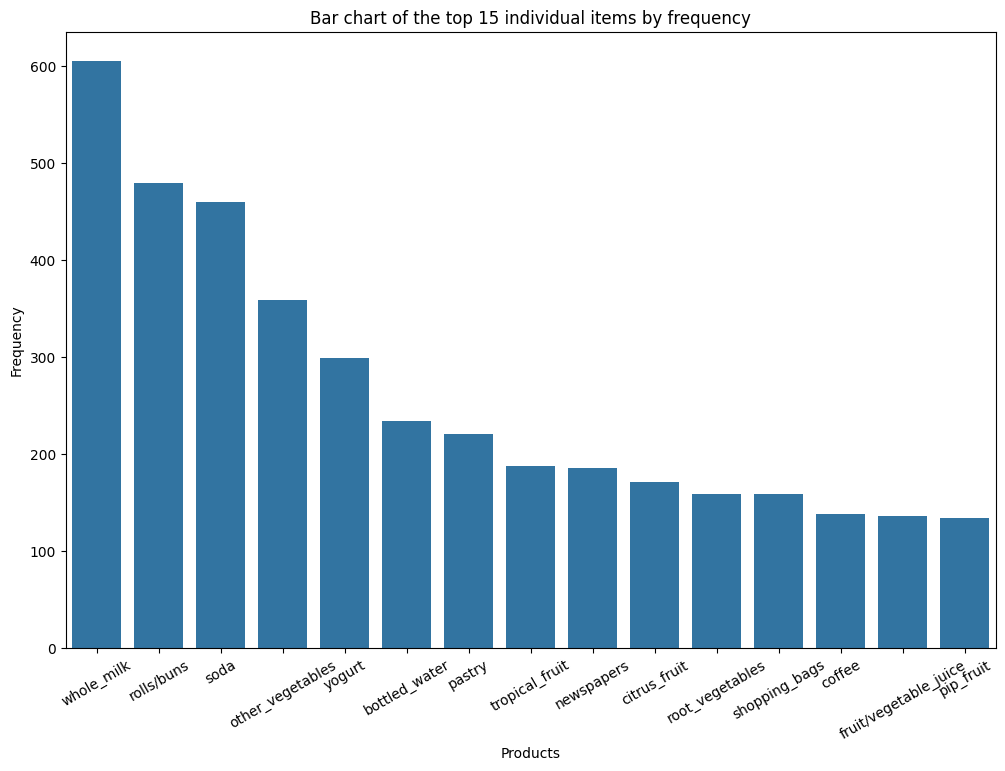

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

NUM_MOST_COMMON = 15

products = [occurance[0] for occurance in product_counter.most_common(NUM_MOST_COMMON)]
counts = [occurance[1] for occurance in product_counter.most_common(NUM_MOST_COMMON)]

plt.figure(figsize=FIGURE_SIZE)
bar_plot = sns.barplot(x=products, y=counts)
bar_plot.set_xticklabels(products, rotation=30)
plt.title("Bar chart of the top 15 individual items by frequency")
plt.xlabel("Products")
plt.ylabel("Frequency")
plt.savefig("files/top15_items_bar.png")
plt.show();

In [24]:
product_counter.most_common(NUM_MOST_COMMON)

[('whole_milk', 605),
 ('rolls/buns', 480),
 ('soda', 460),
 ('other_vegetables', 359),
 ('yogurt', 299),
 ('bottled_water', 234),
 ('pastry', 221),
 ('tropical_fruit', 188),
 ('newspapers', 186),
 ('citrus_fruit', 171),
 ('root_vegetables', 159),
 ('shopping_bags', 159),
 ('coffee', 138),
 ('fruit/vegetable_juice', 136),
 ('pip_fruit', 134)]

*whole_milk* is by far best-selling product by being bought by more than 600 customers. *rolls/buns* and *soda* came second and third places with almost 500 purchases. Other top-selling products are in 130 to 360 range. 

### Bar chart of top-k pairs by support fraction

Now, let's see top-K pairs and their how many groceries have these two items.

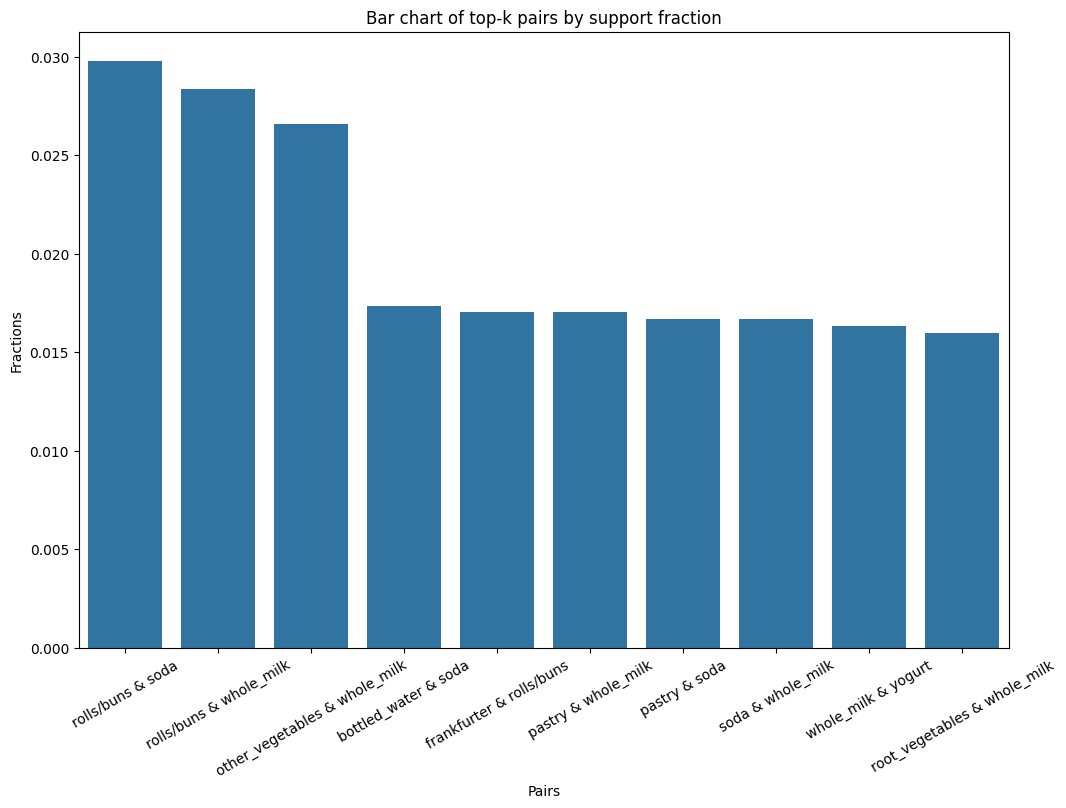

In [25]:
pairs = [' & '.join(occurance[0]) for occurance in pair_counter.most_common(K)]
fractions = [occurance[1]/len(df) for occurance in pair_counter.most_common(K)]

plt.figure(figsize=FIGURE_SIZE)
bar_plot = sns.barplot(x=pairs, y=fractions)
bar_plot.set_xticklabels(pairs, rotation=30)
plt.title("Bar chart of top-k pairs by support fraction")
plt.xlabel("Pairs")
plt.ylabel("Fractions")
plt.savefig("files/topk_pairs_support_fraction_bar.png")
plt.show();

We can see that our groceries dataset is diverse. Even most coocuring pairs are bought by less 3% of customers.

### Heatmap of a co-occurrence matrix for the 25 most frequent items

Next, we will analyze how top-selling products are sold in combination with others. For that, we will get top selling products from `product_counter` and create new dataframe with 0 initial values. Then, we will fill-up with `pair_counter` values of every pairs.

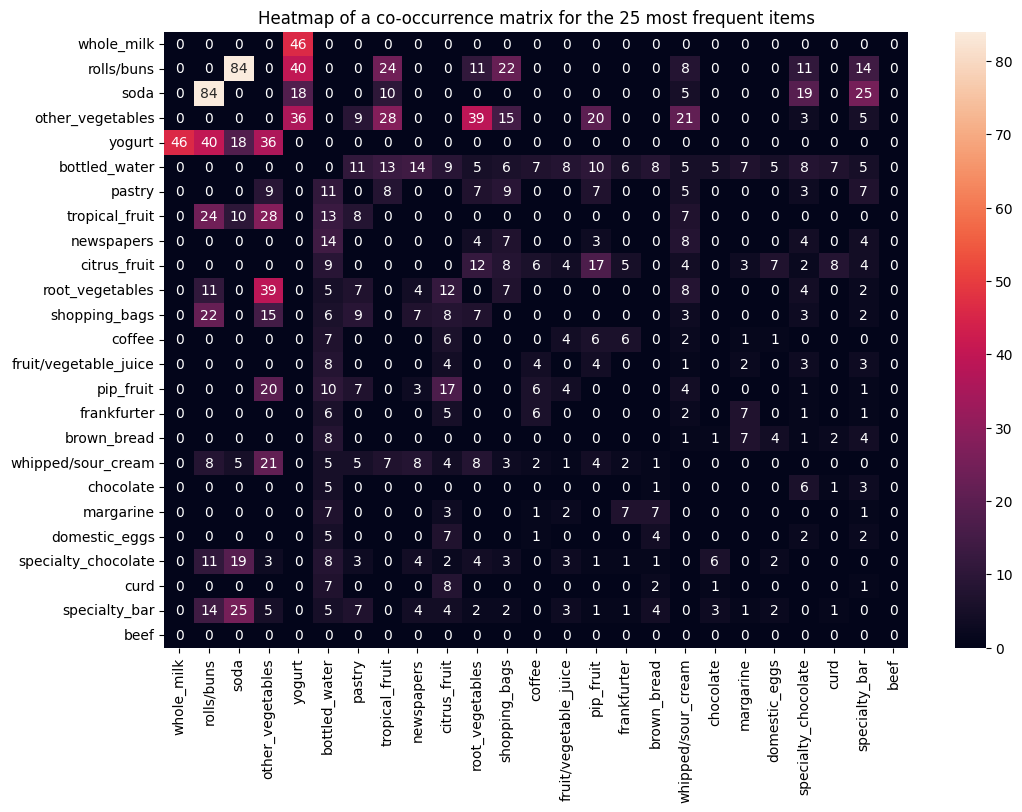

In [26]:
NUM_MOST_FREQUENT = 25
products = [occurance[0] for occurance in product_counter.most_common(NUM_MOST_FREQUENT)]

df_cooccur = pd.DataFrame(data=np.zeros((NUM_MOST_FREQUENT, NUM_MOST_FREQUENT), dtype=np.int16),
                          columns=products, index=products)

for product1, product2 in combinations(products, 2):
    num_occurance = pair_counter.get((product1, product2), 0)
    df_cooccur.at[product1, product2] = num_occurance
    df_cooccur.at[product2, product1] = num_occurance

plt.figure(figsize=FIGURE_SIZE)
sns.heatmap(df_cooccur, annot=True)
plt.title("Heatmap of a co-occurrence matrix for the 25 most frequent items")
plt.savefig("files/25frequent_coocurance_heat.png")
plt.show();

As you can see, there is not much of correlation between these. Especially in the bottom-right corner. The most frequent selling pair is *rolls/buns* with *soda*.

### Hist plot of basket size and basket total

Next, let's investigate how basket size is correlated to total cost of products.

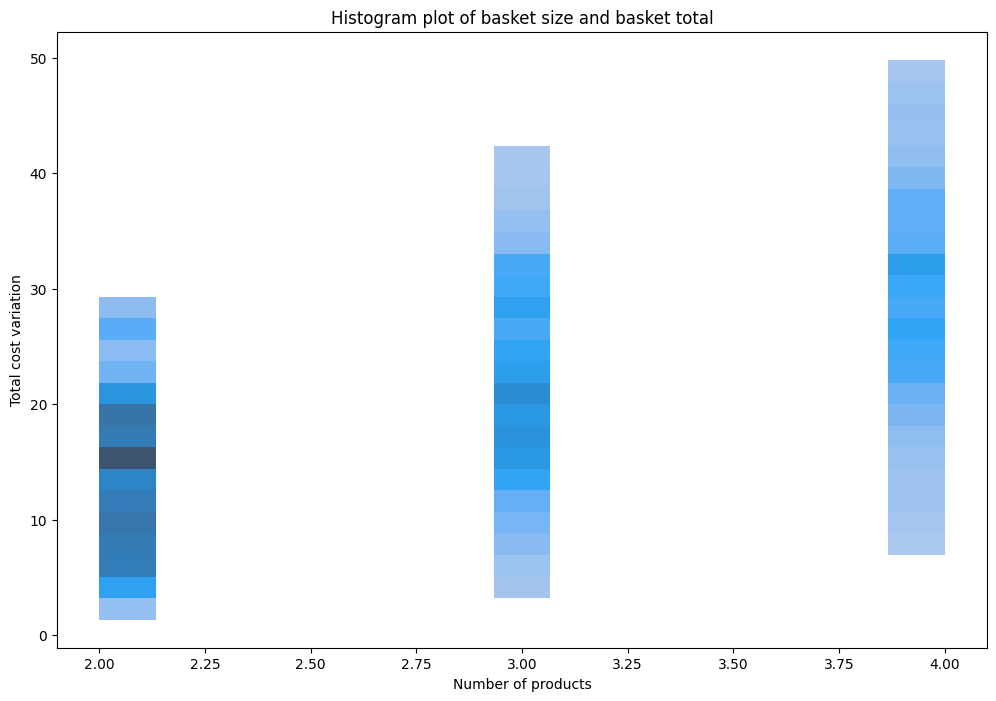

In [27]:
plt.figure(figsize=FIGURE_SIZE)
sns.histplot(x='basket_size', y='basket_total', data=df)
plt.title("Histogram plot of basket size and basket total")
plt.xlabel("Number of products")
plt.ylabel("Total cost variation")
plt.savefig("files/basket-size_basket-total_hist.png")
plt.show();

From the graph, more products often means higher prices. But the variation in price is not high.

### Network graph for top co-occurring pairs

Let's now see visually how top-K products are correlated with each other. For that, we will use `NetworkX` library that we installed in the beginning. The products will be at nodes and the edges will mean how freaquent they apper together.

To get the most advantage, we will try to scale both nodes and edges according to their weight.

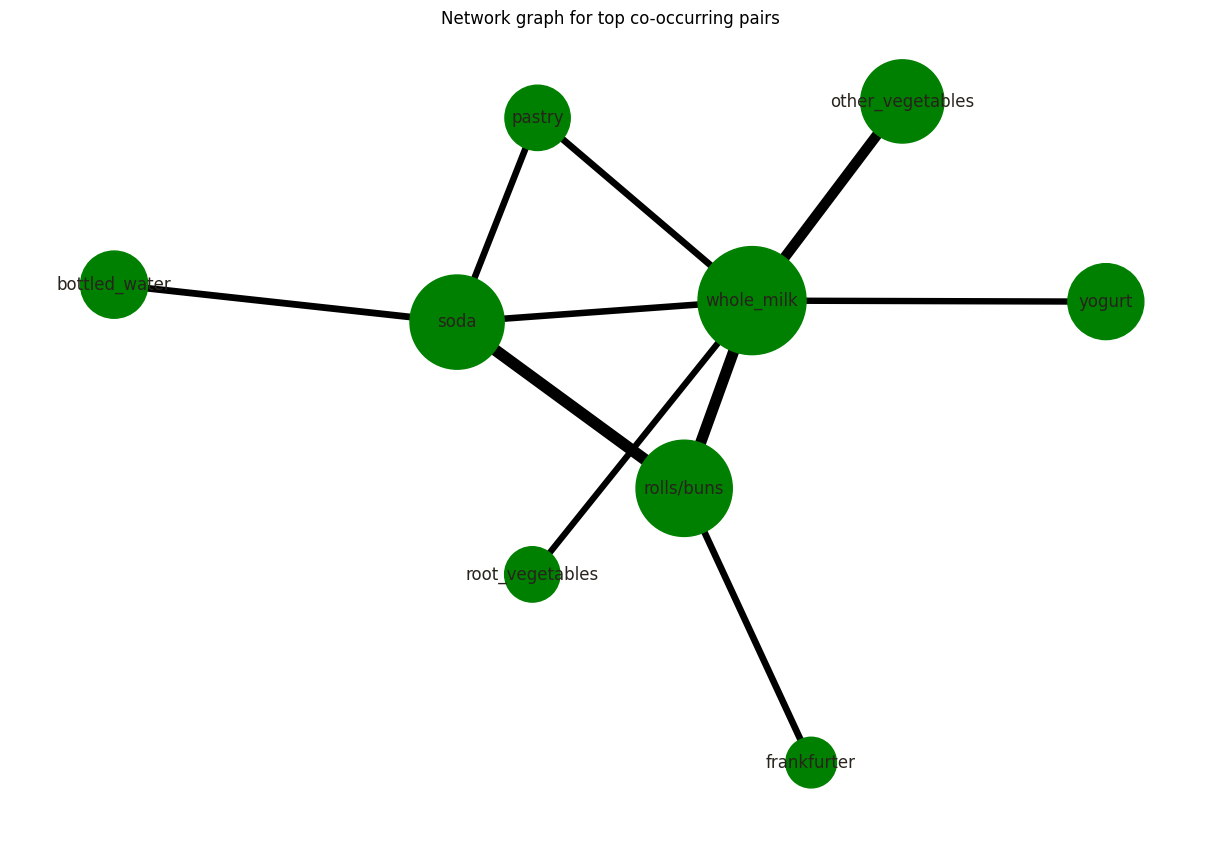

In [28]:
import networkx as nx

G = nx.Graph(set_seed=SEED)

top_pairs = pair_counter.most_common(K)

products = set()
for occurance in top_pairs:
    products.update(occurance[0])

for product in products:
    G.add_node(product, weight=product_counter.get(product, 1))

for occurance in top_pairs:
    G.add_edge(*occurance[0], weight=occurance[1])

node_sizes = [product_counter.get(product, 1)*10 for product in G.nodes()]
edge_sizes = [G[u][v]['weight']/10 for u, v in G.edges()]

plt.figure(figsize=FIGURE_SIZE)
spring_graph = nx.spring_layout(G, seed=SEED)
nx.draw(G, spring_graph, node_size=node_sizes, width=edge_sizes, 
        with_labels=True, node_color='green', edge_color='black', 
        font_color='#28231D')
plt.title("Network graph for top co-occurring pairs")
plt.savefig("files/top-coocuring-pairs_network.png")
plt.show();

There is a good co-occurance between top-selling products like `whole_milk`, `rolls/buns` and `other_vegetables`. But, it is mostly sparse as not all nodes are connected to each other.

# Extensions

### Revenue scenarios

In [29]:
perturbation_ratio = 0.1

def perturb_prices(row) -> float:
    perturbation_value = rng.uniform(1-perturbation_ratio, 1+perturbation_ratio)
    new_price = row['price'] * perturbation_value
    return round(new_price, 2)

df_prices['perturbed_price'] = df_prices.apply(perturb_prices, axis=1)
df_prices.head(5)

,product,price,perturbed_price
0,abrasive_cleaner,2.83,2.89
1,artif_sweetener,0.50,0.48
2,baby_cosmetics,3.64,3.63
3,baking_powder,5.84,5.80
4,bathroom_cleaner,0.53,0.56


In [30]:
perturbed_price_dictionary = {}

for _, row in df_prices.iterrows():
    perturbed_price_dictionary[row['product']] = row['perturbed_price']

def get_total_price(items: list[str], price_dictionary: dict = price_dictionary) -> float:
    total_price = 0.0
    for product in items:
        total_price += price_dictionary[product]
    
    return round(total_price, 2)

df['perturbed_basket_total'] = df['items'].apply(lambda products: get_total_price(products, perturbed_price_dictionary))
df.head(5)

,transaction_id,items,basket_size,basket_total,perturbed_basket_total
0,id_0000,"[citrus_fruit, semi-finished_bread, margarine,...",4,37.77,38.34
1,id_0001,"[tropical_fruit, yogurt, coffee]",3,16.46,16.31
2,id_0003,"[pip_fruit, yogurt, cream_cheese, meat_spreads]",4,29.12,29.67
3,id_0004,"[other_vegetables, whole_milk, condensed_milk,...",4,38.43,37.54
4,id_0007,"[whole_milk, cereals]",2,20.57,19.29


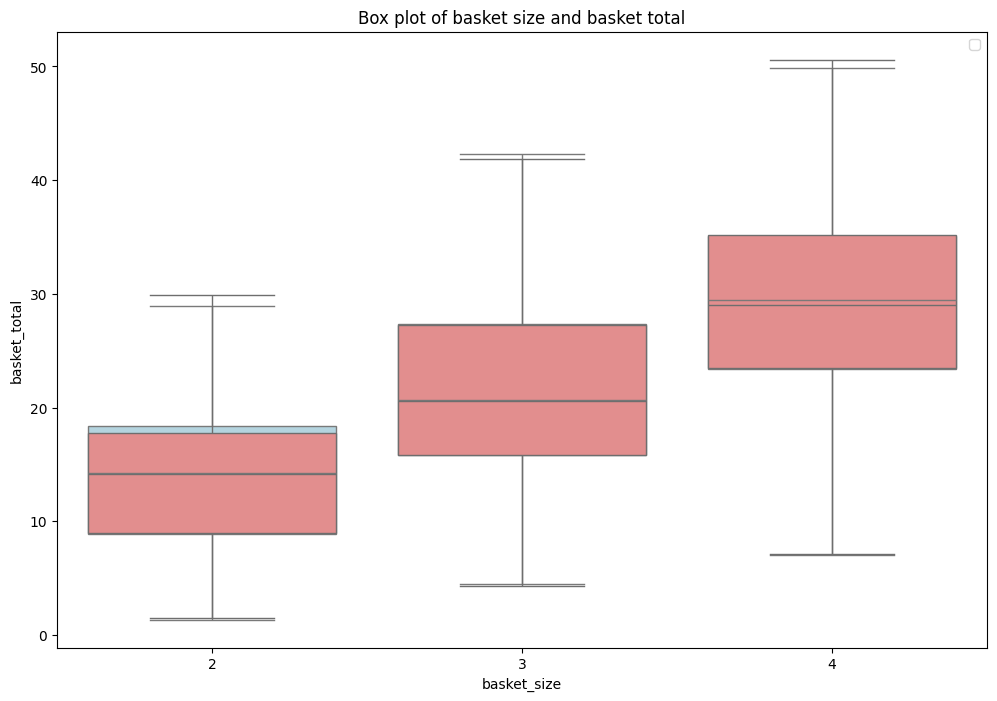

In [31]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)
sns.boxplot(x='basket_size', y='basket_total', data=df, ax=ax, color='lightblue')
sns.boxplot(x='basket_size', y='perturbed_basket_total', data=df, ax=ax, color='lightcoral')
plt.title("Box plot of basket size and basket total")
# plt.savefig("files/basket-size_basket-total_hist.png")
plt.legend()
plt.show();

In [32]:
topk_products = list(df_prices.sort_values(by=['price'], ascending=False)[:K]['product'])
perturbed_topk_products = list(df_prices.sort_values(by=['perturbed_price'], ascending=False)[:K]['product'])

print(f"Top-{K} revenue-contributing products:")
for product in topk_products:
    print(f" - {product}")
print("----")

print(f"Top-{K} revenue-contributing products after perturbation:")
for product in perturbed_topk_products:
    print(f" - {product}")

Top-10 revenue-contributing products:
 - berries
 - sugar
 - light_bulbs
 - syrup
 - frozen_chicken
 - specialty_chocolate
 - whole_milk
 - semi-finished_bread
 - photo/film
 - jam
----
Top-10 revenue-contributing products after perturbation:
 - berries
 - photo/film
 - snack_products
 - specialty_chocolate
 - frozen_chicken
 - long_life_bakery_product
 - light_bulbs
 - salty_snack
 - jam
 - sliced_cheese


In [33]:
common_products = set(topk_products) & set(perturbed_topk_products)
dropped_products = set(topk_products) - common_products
added_products = set(perturbed_topk_products) - common_products

print(f"Products that stayed in Top-{K} after perturbation:")
for product in common_products:
    print(f" - {product}")
print("----")

print(f"Products that droppped from Top-{K} after perturbation:")
for product in dropped_products:
    print(f" - {product}")
print("----")

print(f"Products that newly added to Top-{K} after perturbation:")
for product in added_products:
    print(f" - {product}")

Products that stayed in Top-10 after perturbation:
 - specialty_chocolate
 - photo/film
 - light_bulbs
 - frozen_chicken
 - jam
 - berries
----
Products that droppped from Top-10 after perturbation:
 - sugar
 - semi-finished_bread
 - syrup
 - whole_milk
----
Products that newly added to Top-10 after perturbation:
 - snack_products
 - salty_snack
 - long_life_bakery_product
 - sliced_cheese


### Quality report

Duplicated IDs analysis

In [35]:
all_transaction_ids = df['transaction_id'].tolist()
unique_transaction_ids = set(all_transaction_ids)

if len(all_transaction_ids) == len(unique_transaction_ids):
    print("All `transaction_id`s are unique.")
else:
    print("These `transaction_id`s are duplicated:")
    transaction_id_counter = Counter(all_transaction_ids)
    for transaction_id, count in transaction_id_counter.most_common():
        if count > 1:
            print(f"- {transaction_id} ({count})")


Duplicate IDs analysis:
All `transaction_id`s are unique.


Malformed rows analysis

In [36]:
columns_info = [
    ('transaction_id', str),
    ('items', list),
    ('basket_size', int),
    ('basket_total', float),
    ('perturbed_basket_total', float)
]

malformed_rows = []
for i, row in df.iterrows():
    for column_name, column_type in columns_info:
        if not isinstance(row[column_name], column_type):
            malformed_rows.append(i)
    
if len(malformed_rows) == 0:
    print("Dataset has no malformed rows.")
else:
    print("Malformed_rows:")
    print(df.iloc[malformed_rows]) 

Malformed rows analysis:
Dataset has no malformed rows.


Outlier analysis using IQR method

In [37]:
def get_outliers(df: pd.DataFrame, column_name: str) -> list:
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)][column_name]
    return outliers

for column_name in ['basket_size', 'basket_total', 'perturbed_basket_total']:
    outliers = get_outliers(df, column_name)

    if len(outliers) == 0:
        print(f"{column_name} column has no outliers.")
    else:
        print(f"Outliers from {column_name} column:")
        print(outliers)
    
    print("----")

Outlier analysis:
----
basket_size column has no outliers.
----
Outliers from basket_total column:
74      47.44
253     49.58
428     47.37
650     46.81
786     46.70
1200    48.93
1441    46.52
1548    46.49
1919    46.71
2018    46.93
2217    49.84
2352    48.83
2613    46.32
Name: basket_total, dtype: float64
----
Outliers from perturbed_basket_total column:
74      45.88
253     49.02
428     47.05
786     47.27
973     47.05
1200    49.25
2018    45.81
2217    50.60
2352    48.92
2376    45.77
2581    47.99
2613    47.33
Name: perturbed_basket_total, dtype: float64
----


# Limitations & Next Steps

In this task, we tried to extract some meaningful insights from the data. But, we were severely limited by the data size. The real life data is orders of magnitude larger that what we are provided. I guess this is to test our skills in small datasets then applying all of knowledge to bigger one.

Also, the analysis will be much more interesting if we have real price of priducts. We took uniformly distributed prices, but the price of products in real life will be much more diverse. 